In [1]:
import os

import seaborn as sns
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import xgboost as xgb

from sklearn.model_selection import train_test_split

from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import residuals_plot

from yellowbrick.regressor import PredictionError

In [2]:
seed_value = 42

os.environ['PYTHONHASHSEED']=str(seed_value)
np.random.seed(seed_value)


In [3]:
X_train = pd.read_csv("../dengue_features_train.csv")
y_train = pd.read_csv("../dengue_labels_train.csv")
X_test = pd.read_csv("../dengue_features_test.csv")

In [4]:
feat_eng_path = "../join_these_csvs/"

#train_first_diff = pd.read_csv(feat_eng_path + "train_first_diff.csv")
#train_sec_diff = pd.read_csv(feat_eng_path + "train_sec_diff.csv")
#train_pct_change = pd.read_csv(feat_eng_path + "train_pct_change.csv")

#X_train = X_train.join(train_first_diff, on = X_train.index)
#X_train = X_train.join(train_sec_diff, on = X_train.index)


In [5]:
X_train

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0


In [6]:
y_train

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6
...,...,...,...,...
1451,iq,2010,21,5
1452,iq,2010,22,8
1453,iq,2010,23,1
1454,iq,2010,24,1


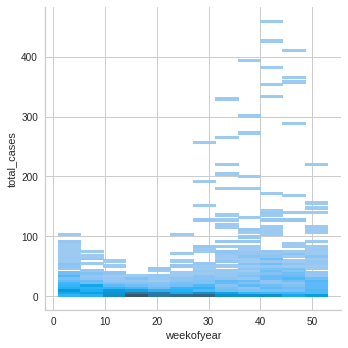

In [7]:
sns.displot(y_train, x = "weekofyear", y = "total_cases")

In [8]:
intense_month_weighting = 0.8
intense_months = list(range(22, 52))


In [9]:
def preprocess_data(df):
    df_new = df.copy()
    
    df_new = df_new.drop(["year", "week_start_date"], axis = 1)
    
    print(df_new.shape)
    # Create seasons categorical variable.
    
    # Interpolate and backfill
    df_new = df_new.interpolate()
    df_new = df_new.fillna(method = "ffill", axis = 1)
    
    df_new["city"] = df_new.city.replace({"sj":0, "iq":1})
    
    df_new = df_new.astype(float)
    df_new["city"] = df_new["city"].astype(int)
    
    return df_new
    

In [10]:
def determine_weights(df, bycity = True):
    weights_series = df["city"]
    pass

In [11]:
X_train_pp = preprocess_data(X_train)
X_test_pp = preprocess_data(X_test)

y_train_pp = y_train.replace({"sj":0, "iq":1})
y_train_pp["city"] = y_train_pp["city"].astype(int)

# Filter for a city
city_num = 0

X_train_pp = X_train_pp.loc[X_train_pp.city == city_num]
X_test_pp = X_test_pp.loc[X_test_pp["city"] == city_num]

y_train_pp = y_train_pp.loc[y_train_pp["city"] == city_num]

# filter to just total_cases
y_train_pp = y_train_pp.total_cases

print(X_train_pp.shape, X_test_pp.shape, y_train_pp.shape)



(1456, 22)
(416, 22)
(936, 22) (260, 22) (936,)


In [12]:
y_train_pp.head()

0    4
1    5
2    4
3    3
4    6
Name: total_cases, dtype: int64

In [60]:
# Set feature weights to total_cases / 2?

X_train_pp["sample_weights"] = len(y_train_pp)/ (y_train_pp+0.001)

(748, 22) (748,) (188, 22) (188,)
[0]	validation_0-mae:25.63499
[1]	validation_0-mae:23.82608
[2]	validation_0-mae:22.08212
[3]	validation_0-mae:20.97621
[4]	validation_0-mae:20.79437
[5]	validation_0-mae:21.23103
[6]	validation_0-mae:21.35854
[7]	validation_0-mae:21.40365
[8]	validation_0-mae:21.89826
[9]	validation_0-mae:22.02769
[10]	validation_0-mae:22.12106
[11]	validation_0-mae:22.26237
[12]	validation_0-mae:22.25447
[13]	validation_0-mae:22.47355
[14]	validation_0-mae:22.27325
[15]	validation_0-mae:22.41829
[16]	validation_0-mae:22.57402
[17]	validation_0-mae:22.76546
[18]	validation_0-mae:22.78589
[19]	validation_0-mae:22.83298
[20]	validation_0-mae:22.77410
[21]	validation_0-mae:22.61279
[22]	validation_0-mae:22.61164
[23]	validation_0-mae:22.57873
[24]	validation_0-mae:22.63222
[25]	validation_0-mae:22.69333
[26]	validation_0-mae:22.73467
[27]	validation_0-mae:22.70666
[28]	validation_0-mae:22.68233
[29]	validation_0-mae:22.69800
[30]	validation_0-mae:22.70096
[31]	validation

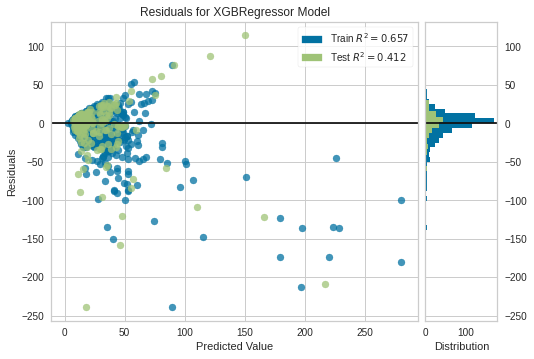

In [65]:
X_train_v, X_test_v, y_train_v, y_test_v = train_test_split(X_train_pp, 
                                                            y_train_pp, 
                                                            test_size=0.20, 
                                                            random_state=42)

train_weights = X_train_v.pop("sample_weights")
valid_weights = X_test_v.pop("sample_weights")

print(X_train_v.shape, y_train_v.shape, X_test_v.shape, y_test_v.shape)

val_set = [(X_test_v, y_test_v)]

xgb_params = {
             "max_depth": 5, 
             "verbosity":1, 
             "n_estimators":500,
             "subsample":0.8,
             "colsample_bytree":0.8,
             "reg_alpha":0.2,
             "objective": "reg:squarederror",
            "tree_method": "exact",
            "eval_metric": "mae"
             }


xgb_clf = xgb.XGBRegressor(**xgb_params)

xgb_clf.fit(X_train_v, y_train_v,
           eval_set = val_set,
           early_stopping_rounds = 100,
#           sample_weight = train_weights
           )

preds = xgb_clf.predict(X_test_v)

#plt.plot(preds)
#plt.show()

viz = residuals_plot(xgb_clf, X_train_v, y_train_v, X_test_v, y_test_v)

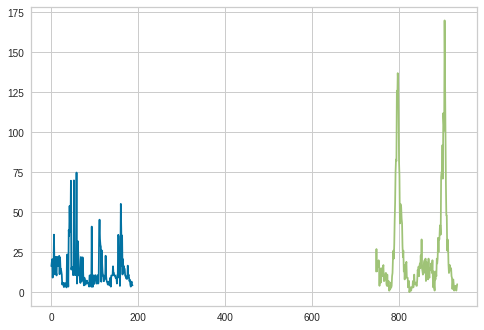

In [62]:
pd.Series(preds).index = pd.Series(y_test_v).sort_index().index
plt.plot(preds)
plt.plot(y_test_v.sort_index())

In [42]:
preds

array([ 16.974209,  23.683817,  16.974209,  24.609867,  16.26463 ,
        16.974209,  16.974209,  24.609867,  13.101218,  32.451767,
        16.974209,  24.147766,  16.974209,  34.862316,  16.974209,
        16.974209,  34.862316,  16.974209,  34.862316,  20.274776,
        16.974209,  15.128412,  16.974209,  24.609867,  26.056026,
        22.76407 ,  16.974209,  24.147766,  16.974209,  15.128412,
        16.26463 ,  34.152737,  24.147766,  16.974209,  16.974209,
        16.974209,  28.578773, 234.51834 ,  24.147766,  24.609867,
        16.26463 ,  24.609867,  32.451767,  24.147766,  31.525715,
        24.609867,  16.974209,  16.26463 ,  24.609867,  19.558224,
        16.974209,  13.101218,  32.451767,  31.742184,  21.638144,
        32.451767,  13.101218, 191.19618 ,  34.862316,  16.974209,
        34.152737,  16.974209,  16.974209,  77.77284 , 122.69956 ,
        26.192448,  31.589352,  16.974209,  26.192448,  51.251106,
        24.609867,  10.476407,  16.974209,  24.147766,  20.274

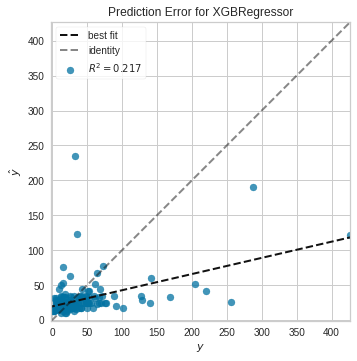

In [28]:
pred_error = PredictionError(xgb_clf)
pred_error.fit(X_train_v, y_train_v).score(X_test_v, y_test_v)
pred_error.show()
plt.show()